In [1]:
import numpy as np
import pandas as pd
import gc
import warnings
import itertools
from copy import deepcopy
from tqdm import tqdm
from pathlib import Path
from matplotlib import pyplot as plt
from typing import *

import math
import random
from collections import namedtuple, deque

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

pd.options.display.max_rows = 200
pd.options.display.max_columns = 400

warnings.filterwarnings("ignore")

/root/.cache/pypoetry/virtualenvs/root-qv7zuvpL-py3.9/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cpu")

In [238]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'reward', 'logprob'))


class ReplayMemory(object):

    def __init__(self):
        self.memory = deque()

    def push(self, state: torch.Tensor, action: torch.Tensor, reward: torch.Tensor, logprob: torch.Tensor) -> None:
        """Save a transition"""
        self.memory.append(Transition(state, action, reward, logprob))

    def __len__(self) -> int:
        return len(self.memory)
    
    def clear(self) -> None:
        self.memory = deque()
    
    def get_batches(self) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        batch = Transition(*zip(*self.memory))
        
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        logprob_batch = torch.cat(batch.logprob)
        
        return state_batch, action_batch, reward_batch, logprob_batch

In [247]:
class ActorCritic(nn.Module):
    def __init__(self, state_dim: int, action_dim: int, device: torch.device, std_init: float=1.0):
        super(ActorCritic, self).__init__()
        self.state_dim = state_dim
        self.action_dim = action_dim
        
        self.device = device
        self.std_init = std_init

        self.actor = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, action_dim)
        )
        
        self.critic = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )
    
    def forward(self):
        raise NotImplementedError
    
    def act(self, state: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        dist = self._get_normal_dist(state=state)
        
        action = dist.sample()
        return action.detach(), dist.log_prob(action).detach()
    
    def evaluate(self, state: torch.Tensor, action: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        dist = self._get_normal_dist(state=state)
        
        action_logprobs = dist.log_prob(action)
        dist_entropy = dist.entropy()
        state_values = self.critic(state)
        
        return action_logprobs, state_values, dist_entropy
        
    def _get_normal_dist(self, state: torch.Tensor) -> torch.distributions.MultivariateNormal:
        _mean = self.actor(state)
        _cov_mat = torch.diag(torch.full((self.action_dim,), self.std_init ** 2, dtype=torch.float32)).to(self.device)
        return torch.distributions.MultivariateNormal(_mean, _cov_mat)
    

class PPO(object):
    def __init__(self, state_dim: int, action_dim: int, device: torch.device, params: Dict[str, Any]):
        self.device = device
        
        self.gamma = params["GAMMA"]
        self.eps_clip = params["EPS_CLIP"]
        self.K_epochs = params["K_EPOCHS"]
        
        self.memory = ReplayMemory()
        
        self.policy = ActorCritic(state_dim=state_dim, action_dim=action_dim, device=device, std_init=params["STD_INIT"]).to(device)
        self.optimizer = torch.optim.Adam([
            {"params": self.policy.actor.parameters(), "lr": params["LR_ACTOR"]},
            {"params": self.policy.critic.parameters(), "lr": params["LR_CRITIC"]},
        ])
        
        self.policy_old = ActorCritic(state_dim=state_dim, action_dim=action_dim, device=device, std_init=params["STD_INIT"]).to(device)
        self.policy_old.load_state_dict(self.policy.state_dict())
        
        self.MseLoss = nn.MSELoss()
    
    def select_action(self, state: torch.Tensor) -> Tuple[np.ndarray, float]:
        with torch.no_grad():
            action, action_logprob = self.policy_old.act(state=state)
            return action, action_logprob
        
    def store_transition(
        self, 
        state: torch.Tensor, 
        action: torch.Tensor,
        reward: torch.Tensor, 
        logprob: torch.Tensor,
    ) -> None:
        self.memory.push(state=state, action=action, reward=reward, logprob=logprob)
    
    def update(self):
        state_batch, action_batch, reward_batch, logprob_batch = self.memory.get_batches()
        
        old_rewards = self._calc_cumsum_discount_rewards(reward_batch=reward_batch)
        
        old_states = state_batch.detach().to(self.device)
        old_actions = action_batch.detach().to(self.device)
        old_logprobs = logprob_batch.detach().to(self.device)
        
        for _ in range(self.K_epochs):
            logprobs, state_values, dist_entropy = self.policy.evaluate(state=old_states, action=old_actions)
            state_values = torch.squeeze(state_values)
            
            ratios = torch.exp(logprobs - old_logprobs.detach())
            
            advantages = old_rewards - state_values.detach()   
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1 - self.eps_clip, 1 + self.eps_clip) * advantages
            
            loss = -torch.min(surr1, surr2) + 0.5 * self.MseLoss(state_values, old_rewards) - 0.01 * dist_entropy
            
            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()
        
        self.policy_old.load_state_dict(self.policy.state_dict())
        
        self.memory.clear()
    
    def _calc_cumsum_discount_rewards(self, reward_batch: np.ndarray) -> np.ndarray:
        reward_batch = reward_batch.squeeze()
        cumsum_discounted_rewards = deque()
        _discounted_reward = 0
        for reward in reversed(reward_batch):
            _discounted_reward = reward + self.gamma * _discounted_reward
            cumsum_discounted_rewards.appendleft(_discounted_reward)
        cumsum_discounted_rewards = torch.tensor(cumsum_discounted_rewards, dtype=torch.float32).to(self.device)
        
        def normalize(x: torch.Tensor) -> torch.Tensor:
            return (x - x.mean()) / (x.std() + 1e-7)
                
        return normalize(x=cumsum_discounted_rewards)
    
    def save_model(self, filepath: Path) -> None:
        torch.save(self.policy_old.state_dict(), filepath)

### QA
- 行動の標準偏差について
- 行動が混合変数の場合について
- ReplayMemoryとbufferについて、上限などあるか

### Training

In [298]:
def get_random_state(dim: int) -> torch.Tensor:
    # return torch.from_numpy(np.ones(dim).astype(np.float32)).view(1, -1)
    return torch.from_numpy((np.random.rand(dim) > 0.5).astype(np.float32)).view(1, -1)


def get_fixed_reward(action: np.ndarray) -> float:
    return action[1]
    action_idx = action.argmax()
    if actions[action_idx] == "Down":
        return 1
    elif actions[action_idx] == "Up":
        return 0
    elif actions[action_idx] == "Hold":
        return -1

In [299]:
ppo_params = {
    "GAMMA": 0.999,
    "EPS_CLIP": 0.2,
    "K_EPOCHS": 80,
    "STD_INIT": 1,
    "LR_ACTOR": 0.0003,
    "LR_CRITIC": 0.001,
}

In [300]:
actions = np.array(["Hold", "Up", "Down"])
n_actions = actions.shape[0]
state_dim = 10

In [301]:
agent = PPO(state_dim=state_dim, action_dim=n_actions, device=device, params=ppo_params)

episode_durations = []
action_log = list()
num_episodes = 50
for i_episode in tqdm(range(num_episodes)):
    rewards = list()
    # Initialize the environment and state
    state = get_random_state(state_dim)
    for t in range(5):
        # Select and perform an action
        action, action_logprob = agent.select_action(state=state)
        reward = get_fixed_reward(action=action.detach().numpy().squeeze())
        rewards.append(reward)
        action_log.append(action.detach().numpy().squeeze())
        
        reward = torch.tensor([reward], device=device, dtype=torch.float32)
        
        # Store the transition in memory
        agent.store_transition(state=state, action=action, reward=reward, logprob=action_logprob)

        # Observe new state
        state = get_random_state(state_dim)

    agent.update()
    
    episode_durations.append(np.mean(rewards))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.70it/s]


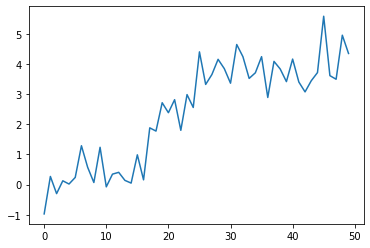

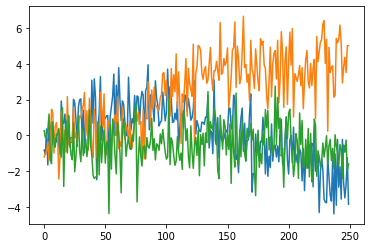

In [302]:
plt.plot(episode_durations)
plt.show()
plt.plot(np.array(action_log))